# Titanic: Machine Learning from Disaster (Tensorflow Linear Classifier)

This file is my first attempt to build a machine learning model to predict the survival of passengers on the Titanic for a Kaggle competetition.

The model implements a linear classifier from Tensorflow in Python.



### Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
files.upload()

### Data

In [268]:
# Construct pandas dataframe from csv files
dftrain = pd.read_csv('train.csv')
dfeval = pd.read_csv('test.csv')

# Preprocess the dataframes
def preprocess(df):
  #df = df.dropna(subset=['Embarked'])
  df['Deck'] = df['Cabin'].str.get(0)
  df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
  df['Age'] = df['Age'].fillna(df['Age'].mean())
  df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
  df['Deck'] = df['Deck'].fillna('M')
  df['Embarked'] = df['Embarked'].fillna('M')
  return df

dftrain = preprocess(dftrain)
y_train = dftrain.pop('Survived')

dfeval = preprocess(dfeval)
dfeval['Survived'] = np.nan
y_eval = dfeval.pop('Survived')
ids = dfeval.pop('PassengerId')

In [270]:
dftrain.head(10) # Check the first 10 entries in the training dataset

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,1,3,male,22.000000,1,0,7.2500,S,M
1,2,1,female,38.000000,1,0,71.2833,C,C
2,3,3,female,26.000000,0,0,7.9250,S,M
3,4,1,female,35.000000,1,0,53.1000,S,C
4,5,3,male,35.000000,0,0,8.0500,S,M
5,6,3,male,29.699118,0,0,8.4583,Q,M
6,7,1,male,54.000000,0,0,51.8625,S,E
7,8,3,male,2.000000,3,1,21.0750,S,M
8,9,3,female,27.000000,0,2,11.1333,S,M
9,10,2,female,14.000000,1,0,30.0708,C,M


Plot out statistical data

Text(0.5, 0, 'Fare')

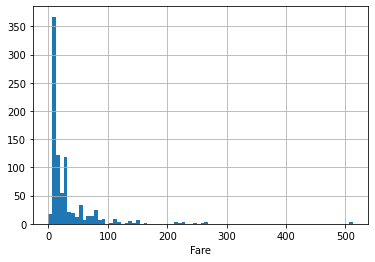

In [269]:
dftrain.Fare.hist(bins=80).set_xlabel('Fare')

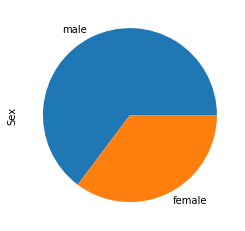

In [ ]:
dftrain.Sex.value_counts().plot(kind='pie')

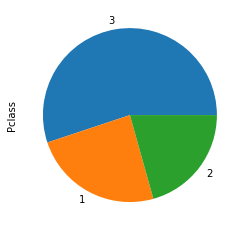

In [ ]:
dftrain.Pclass.value_counts().plot(kind='pie')

Text(0.5, 0, '% survive')

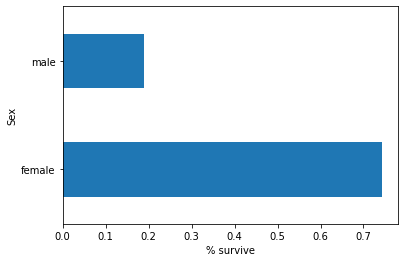

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('Sex').Survived.mean().plot(kind='barh').set_xlabel('% survive')

Text(0.5, 0, '% survive')

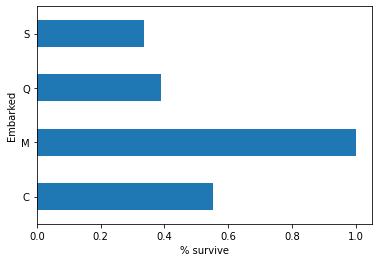

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('Embarked').Survived.mean().plot(kind='barh').set_xlabel('% survive')

Text(0.5, 0, '% survive')

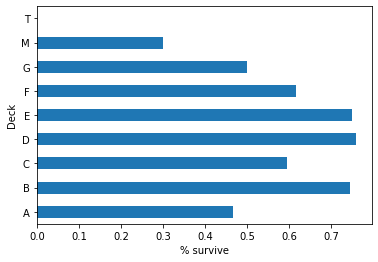

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('Deck').Survived.mean().plot(kind='barh').set_xlabel('% survive')

### Feature Columns

Set up the relevant features that will be used in our linear classifier model

In [ ]:
categorical_columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
numeric_columns = ['Age', 'Fare']

feature_columns = []
for feature_name in categorical_columns:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in numeric_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

### Input Function

Constructs input functions out of our dataframes so they may be processed with TensorFlow. The linear classifier uses mini-batch regression, so further expand and process the data by duplicating and shuffling the entries.

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

Train the linear classifier.

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(input_fn=train_input_fn)

Make predictions on the test data with our trained linear classifier.

In [ ]:
predictions = list(linear_est.predict(eval_input_fn))
class_list = []
for pred in predictions:
  class_list.append(pred['class_ids'][0])
len(class_list)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpto3dw19y/model.ckpt-280
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


418

Convert the test dataframe and predictions into a single csv file for submission.

In [280]:
submission = pd.DataFrame(ids)
submission['Survived'] = class_list
submission.reset_index(drop=True)
submission.to_csv('titanicLC_submission.csv', index=False)

files.download('titanicLC_submission.csv')

FileNotFoundError: ignored